In [1]:
image_path_ct = '/work/kovo/Downloads/1.3.6.1.4.1.9328.50.4.0002-20250115T155752Z-001/1.3.6.1.4.1.9328.50.4.0002/01-01-2000-1-Abdomen24ACRINColoIRB2415-04 Adult-.1240/3.000000-Colosupine  1.0  B30f-.1840'
#image_path_ct = '/content/drive/MyDrive/Sxolh/Random DICOM Images/archive/dicom_dir'
image_path_sych = '/work/kovo/Downloads/40.05um_LADAF-2021-17_colon_complete-organ_pag-0.02_0.09'
segmentation_path = '/work/kovo/Desktop/Jon Project/Segmentation Result'
segmentation_path_ALL = "/home/kovo/Desktop/root-painter-sync/projects/ColonSeg13_1_25_SegmentALL/Segmentation Results"
segmentation_result_Aggressive = "/home/kovo/Desktop/root-painter-sync/projects/ColonSeg08012025/Segmentation Result"

## Packages

In [2]:
from pathlib import Path
from pydicom import dcmread
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splrep, splev
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d, RegularGridInterpolator
from tqdm import tqdm

import scipy.optimize as optimize
plt.rcParams['image.cmap'] = 'gray'

import os
import cv2


## CT Import

In [3]:
images_ct = []

for filename in os.listdir(image_path_ct):
    file_path = os.path.join(image_path_ct, filename)

    dicom_data = dcmread(file_path)
    image = dicom_data.pixel_array.astype(float)

    # Get RescaleSlope and RescaleIntercept from DICOM metadata
    rescale_slope = dicom_data.RescaleSlope if 'RescaleSlope' in dicom_data else 1
    rescale_intercept = dicom_data.RescaleIntercept if 'RescaleIntercept' in dicom_data else 0

    # Convert pixel values to Hounsfield Units (HU)
    hu_image = (image * rescale_slope) + rescale_intercept
    #hu_image = image

    images_ct.append(np.flip(hu_image, axis=0).astype(np.int64))
stacked = np.stack(images_ct, axis=0)

In [4]:
path_to_first_file = next(os.scandir(image_path_ct), None)
dcm_file = dcmread(path_to_first_file)
print(f"Number of images: {stacked.shape[0]}")
print(f"Size of image: {stacked.shape[1]}x{stacked.shape[2]}")
print(f"Pixel size: {dcm_file.PixelSpacing} mm")
pixel_size_x = dcm_file.PixelSpacing[1]
pixel_size_y = dcm_file.PixelSpacing[0]

pixel_size = dcm_file.PixelSpacing[1]
print(pixel_size_x)

Number of images: 617
Size of image: 512x512
Pixel size: [0.78125, 0.78125] mm
0.78125


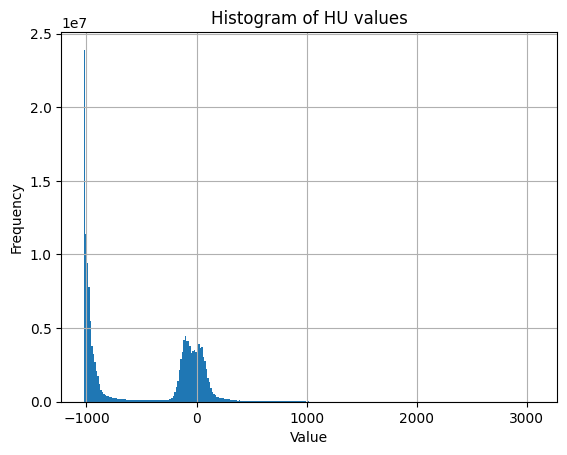

In [5]:
flattened_stacked = stacked.flatten()
#hist, bins = np.histogram(flattened_stacked, bins=300)
plt.hist(flattened_stacked, bins=300)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of HU values')
plt.grid()
plt.show()

## Sychnotron

## Manual Translation

In [5]:
contrasted_filepath = '/work/kovo/Desktop/Jon Project/Contrasted'
transformed_filepath_otsu = '/work/kovo/Desktop/Jon Project/Transformed/'
thres_filepath_otsu = '/work/kovo/Desktop/Jon Project/Thresholded/'
noisy_filepath_otsu = '/work/kovo/Desktop/Jon Project/Noisy/'

transformed_filepath_root = '/work/kovo/Desktop/Jon Project/Transformed RootPainter/'
thres_filepath_root= '/work/kovo/Desktop/Jon Project/Thresholded Rootpaiter/'
noisy_filepath_root = '/work/kovo/Desktop/Jon Project/Noisy Rootpainter/'

noisy_filepath_histmatch = '/work/kovo/Desktop/Jon Project/Histogram Matching/'

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_and_histogram(image, ylim= None):
    plt.figure(figsize=(12, 6))
    
    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.title("Image")
    
    # Display the histogram
    plt.subplot(1, 2, 2)
    plt.hist(image.ravel(), bins=256, color='black', alpha=0.7)
    
    plt.title("Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    if ylim != None:
        plt.ylim([0, ylim])
    
    plt.tight_layout()
    plt.show()

def show_image_and_histogram_save(image, ylim= None, savepath = None):
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    if savepath != None:
        plt.savefig(savepath+ "IMG.jpg", bbox_inches='tight', pad_inches=0)
    plt.show()
    
    plt.hist(image.ravel(), bins=300, alpha=0.7)
    if ylim != None:
        plt.ylim([0, ylim])
    
    if savepath != None:
        plt.savefig(savepath+ "HIST.jpg", bbox_inches='tight', pad_inches=0)
    plt.show()

In [7]:
def find_99_percent_range(image_copy):
    
    unique_values, counts = np.unique(image_copy.flatten(), return_counts=True)

    # Calculate the cumulative sum of counts
    cumulative_counts = np.cumsum(counts)
    
    # Normalize to get cumulative proportions
    cumulative_proportions = cumulative_counts / cumulative_counts[-1]
    
    # Find indices where theå cumulative proportion reaches 0.005 and 0.995
    lower_index = np.searchsorted(cumulative_proportions, 0.001)
    upper_index = np.searchsorted(cumulative_proportions, 0.999)
    
    # Retrieve the corresponding unique values
    lower_bound = unique_values[lower_index]
    upper_bound = unique_values[upper_index]
    
    return lower_bound, upper_bound

def remove_outline(image):

    image_copy = np.copy(image)
    
    height, width = image_copy.shape
    center = (height // 2, width // 2)  # Center of the circle
    radius = 1650  # Set the desired radius

    # Create a mask for pixels within the circle
    Y, X = np.ogrid[:height, :width]
    distance_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
    circular_mask = distance_from_center <= radius

    # remove radius area around the center circle, make it same as outside values (11912)
    image_copy[~circular_mask] = image_copy[0,0]
    
    return image_copy

def adjust_contrast(image_copy, min_value = None, max_value = None):
    # Define the useful range for contrast adjustment
    if min_value == None or max_value == None:
        min_value , max_value =  find_99_percent_range(image_copy)  # Adjust as needed for your specific range

    # Stretch the contrast within the useful range
    contrast_image = np.clip((image_copy - min_value) * (65535 / (max_value - min_value)), 0, 65535)

    # Convert the result to uint16
    contrast_image = np.uint16(contrast_image)
    return contrast_image

def otsu(input_image):
    image = np.copy(input_image)
    ret, thresh1 = cv2.threshold(image, np.min(image), np.max(image), cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    image[image < ret] = 0
    
    height, width = image.shape
    center = (height // 2, width // 2)  # Center of the circle
    radius = 1650  # Set the desired radius

    # Create a mask for pixels within the circle
    Y, X = np.ogrid[:height, :width]
    distance_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
    circular_mask = distance_from_center <= radius

    # remove radius area around the center circle, make it same as outside values (11912)
    image[~circular_mask] = 0
    
    return ret, image, thresh1

# Translates image to Hounsfield units
def transform(image):
    air_ct = -1000 
    air_sych = 0 # Average value of background

    colon_ct = 30
    colon_sych = 39000 #Experimental value # image[image>0].mean() # Average value of foreground
    
    x1, y1 = air_sych, air_ct   # Example values; replace with actual data
    x2, y2 = colon_sych, colon_ct  # Example values; replace with actual data

    # Calculate the slope (a)
    slope = (y2 - y1) / (x2 - x1)

    # Calculate the intercept (b)
    intercept = y1 - slope * x1

    return (image * slope) + intercept #, intercept, slope

def backgroundNoise(image, mask):

    mean_noise = -1000
    variance_noise = 566.1865234375  # Example variance for 16-bit; adjust as needed
    std_dev_noise = 2*np.sqrt(variance_noise)
    mask = mask.astype(bool)
    
    # Generate Gaussian noise
    noise = np.random.normal(mean_noise, std_dev_noise, image.shape)
    
    noisy_image = np.copy(image)  #
    noisy_image[~mask] = noise[~mask]  # Add noise where mask == 0
    noisy_image[noisy_image < -1000] = -1000
    return noisy_image


def preprocess_image(image):
    
    image_copy = np.copy(image)
    adjusted_contrast = adjust_contrast(remove_outline(image_copy))
    _, thresholded, mask = otsu(adjusted_contrast)
    transformed = transform(thresholded)
    noisy_image = backgroundNoise(transformed, mask)
    return adjusted_contrast, thresholded, transformed, noisy_image

def transform_image(i):
    image_file = image_files_sych[i]
    image = np.copy(image_array_sych[i])
    adjusted_contrast = adjust_contrast(image, lower, upper)
    
    # OTSU
    _, thresholded, mask = otsu(adjusted_contrast)
    transformed = transform(thresholded)
    noisy_image = backgroundNoise(transformed, mask)
    
    seg_otsu_arr.append(thresholded)
    transformed_otsu_arr.append(transformed)
    noisy_otsu_arr.append(noisy_image)
    
    end = image_file.split('/')[-1].split('.jp2')[0] + '.jpg'
    end_png = image_file.split('/')[-1].split('.jp2')[0] + '.png'
    
    #ROOT
    kernel = np.ones((5, 5), np.uint8) 
    segmask_path = os.path.join(segmentation_path, end_png)
    
    segmask = cv2.imread(segmask_path, cv2.IMREAD_GRAYSCALE)
    
    img_erosion = cv2.erode(segmask, kernel, iterations=3) 
    mask = cv2.dilate(img_erosion, kernel, iterations=3) 
    thresholded_image_root = np.where(mask > 0, adjusted_contrast, 0)
    
    transformed_root = transform(thresholded_image_root)
    noisy_image_root = backgroundNoise(transformed_root, mask)

    return adjusted_contrast, thresholded, transformed, noisy_image, thresholded_image_root, transformed_root, noisy_image_root

In [8]:
image_files_sych = [os.path.join(image_path_sych, f) for f in os.listdir(image_path_sych) if (f.endswith('jp2') or f.endswith('jpg'))]
image_files_sych.sort()
image_array_sych = [] 
for image_file in tqdm(image_files_sych):
    #image = preprocess_image(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))
    image = remove_outline(cv2.imread(image_file, cv2.IMREAD_UNCHANGED))
    image_array_sych.append(image)

image_array_sych = np.array(image_array_sych)
lower, upper = find_99_percent_range(image_array_sych)

100%|███████████████████████████████████████| 1000/1000 [08:41<00:00,  1.92it/s]


In [ ]:
contrasted = []
seg_otsu_arr = []
transformed_otsu_arr = []
noisy_otsu_arr = []

seg_root_arr = []
transformed_root_arr = []
noisy_root_arr = []

for i, image_file in tqdm(enumerate(image_files_sych)):
    end = image_file.split('/')[-1].split('.jp2')[0] + '.jpg'
    end_png = image_file.split('/')[-1].split('.jp2')[0] + '.png'
    
    adjusted_contrast = adjust_contrast(image_array_sych[i], lower, upper)
    contrasted.append(adjusted_contrast)
    plt.imsave(os.path.join(contrasted_filepath, end), adjusted_contrast)
    
    # OTSU
    _, thresholded, mask = otsu(adjusted_contrast)
    transformed = transform(thresholded)
    noisy_image = backgroundNoise(transformed, mask)
    
    seg_otsu_arr.append(thresholded)
    transformed_otsu_arr.append(transformed)
    noisy_otsu_arr.append(noisy_image)
    plt.imsave(os.path.join(thres_filepath_otsu, end), thresholded)
    plt.imsave(os.path.join(transformed_filepath_otsu, end), transformed)
    plt.imsave(os.path.join(noisy_filepath_otsu, end), noisy_image)
    
    
    #ROOT
    kernel = np.ones((5, 5), np.uint8) 
    segmask_path = os.path.join(segmentation_path, end_png)
    
    segmask = cv2.imread(segmask_path, cv2.IMREAD_GRAYSCALE)
    
    img_erosion = cv2.erode(segmask, kernel, iterations=3) 
    mask = cv2.dilate(img_erosion, kernel, iterations=3) 
    thresholded_image_root = np.where(mask > 0, adjusted_contrast, 0)
    
    transformed_root = transform(thresholded_image_root)
    noisy_image_root = backgroundNoise(transformed_root, mask)
    
    
    seg_root_arr.append(thresholded_image_root)
    transformed_root_arr.append(transformed_root)
    noisy_root_arr.append(noisy_image_root)
    plt.imsave(os.path.join(thres_filepath_root, end), thresholded_image_root)
    plt.imsave(os.path.join(transformed_filepath_root, end), transformed_root)
    plt.imsave(os.path.join(noisy_filepath_root, end), noisy_image_root)

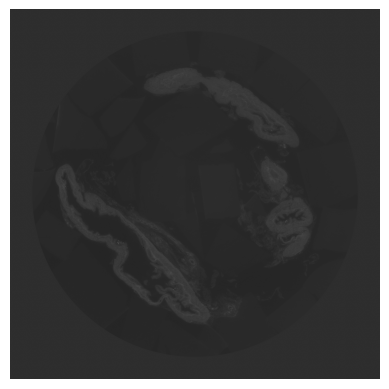

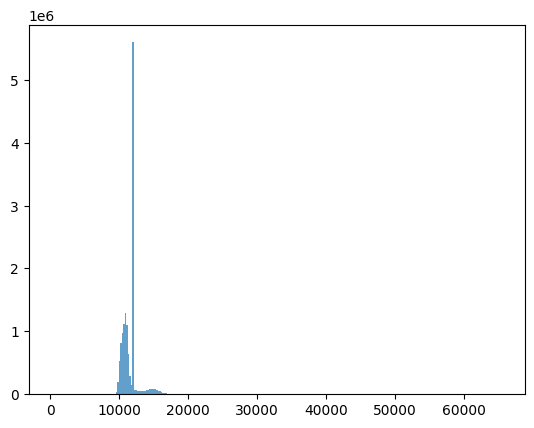

In [23]:
show_image_and_histogram_save(image_array_sych[900], savepath = "MANUAL_ORIGINAL")

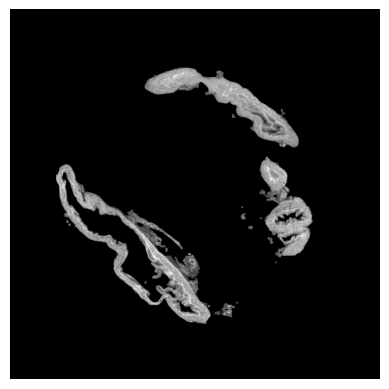

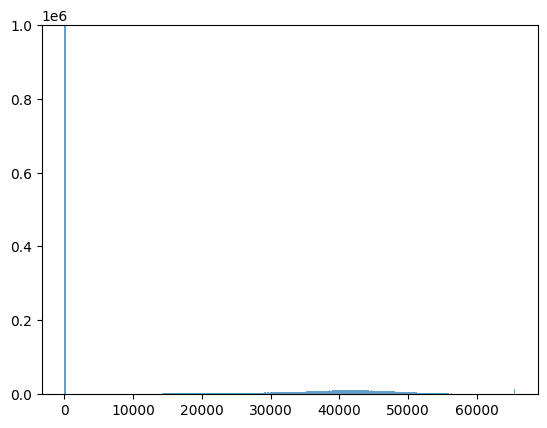

In [27]:
show_image_and_histogram_save(seg_root_arr[900], ylim=1e6, savepath = "MANUAL_segment")

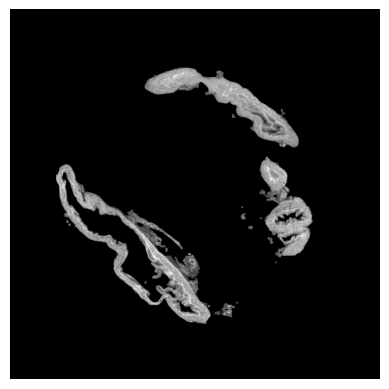

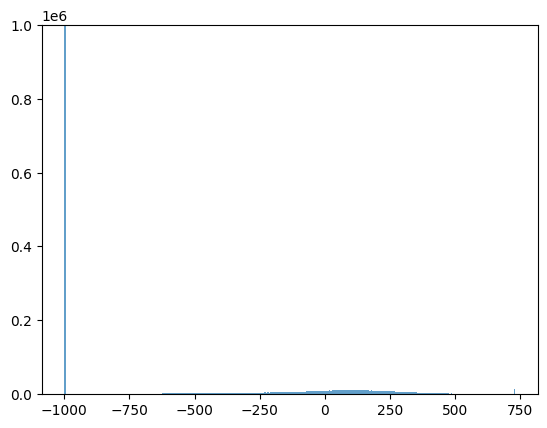

In [28]:
show_image_and_histogram_save(transformed_root_arr[900], ylim=1e6, savepath = "MANUAL_transformed")

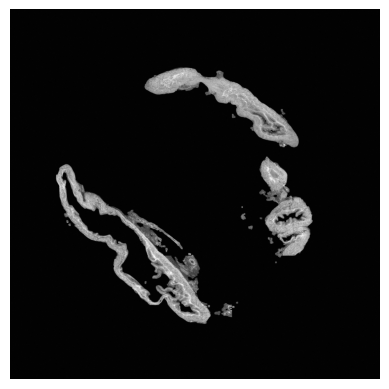

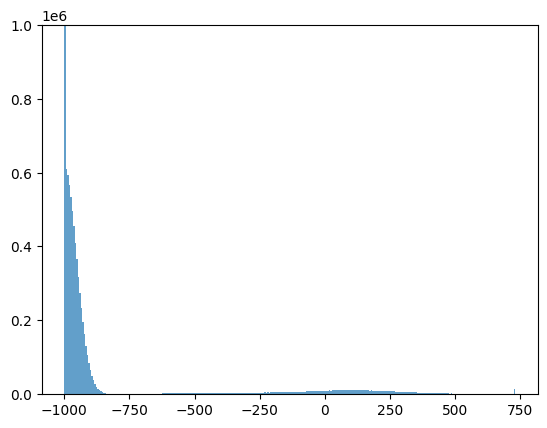

In [29]:
show_image_and_histogram_save(noisy_root_arr[900], ylim=1e6, savepath = "MANUAL_final")

## Histogram matching

In [225]:
import os
images_ct = []
images_ct_unchanged = []

for filename in os.listdir(image_path_ct):
    file_path = os.path.join(image_path_ct, filename)

    dicom_data = dcmread(file_path)
    image = dicom_data.pixel_array.astype(float)

    # Get RescaleSlope and RescaleIntercept from DICOM metadata
    rescale_slope = dicom_data.RescaleSlope if 'RescaleSlope' in dicom_data else 1
    rescale_intercept = dicom_data.RescaleIntercept if 'RescaleIntercept' in dicom_data else 0

    # Convert pixel values to Hounsfield Units (HU)
    hu_image = (image * rescale_slope) + rescale_intercept
    hu_image_unchanged = image

    images_ct.append(np.flip(hu_image, axis=0).astype(np.int64))
    
    images_ct_unchanged.append(np.flip(hu_image_unchanged, axis=0).astype(np.int64))
stacked = np.stack(images_ct, axis=0)
stacked_unchanged = np.stack(images_ct_unchanged)


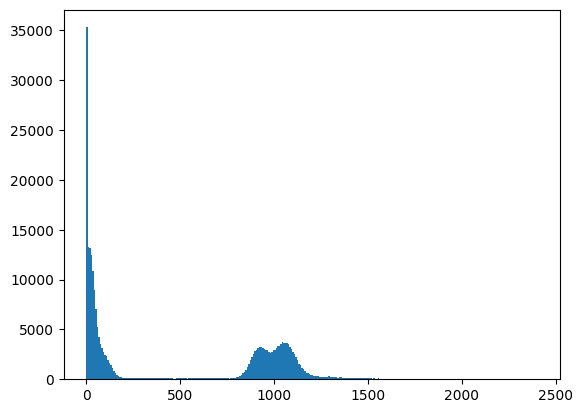

In [227]:
plt.hist(stacked_unchanged[30].flatten(), bins=300)
plt.show()

In [ ]:
from skimage.exposure import match_histograms

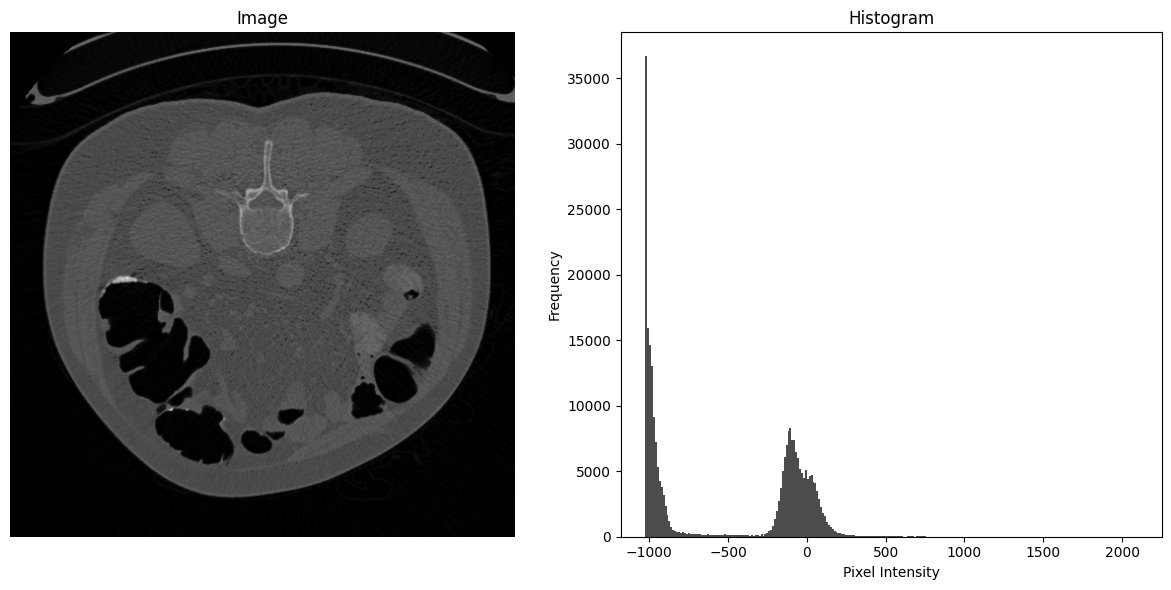

In [229]:
matched_image = match_histograms(stacked[20], stacked[300])
show_image_and_histogram(matched_image)

## CT

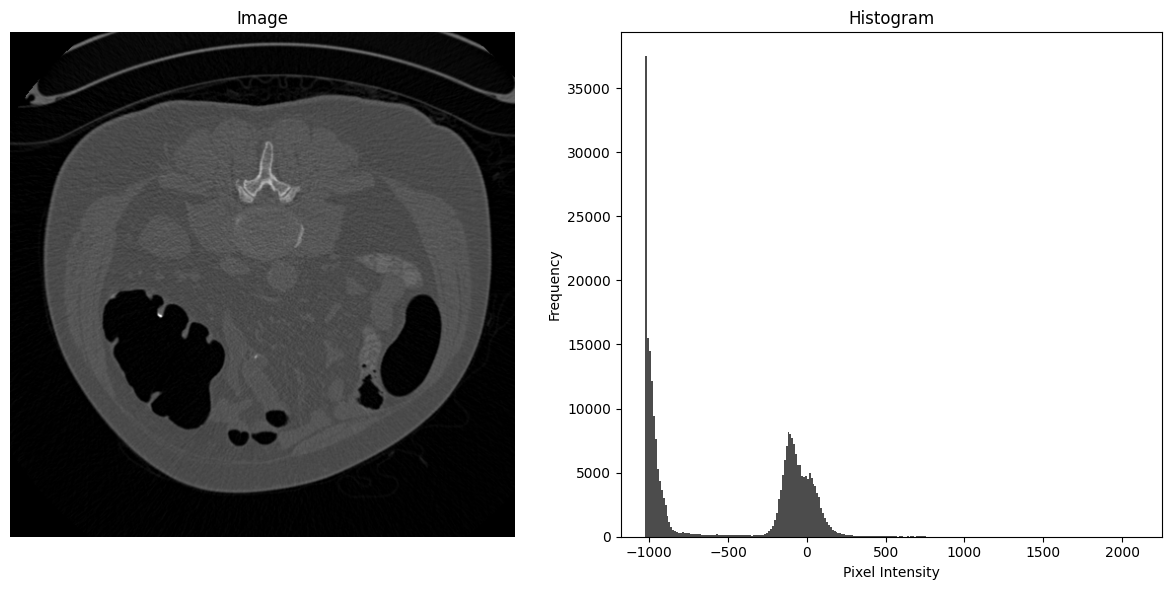

In [211]:
show_image_and_histogram(stacked[300])

In [212]:
adjusted_contrast = adjust_contrast(image_array_sych[500])
_, thresholded, mask = otsu(adjusted_contrast)
transformed = transform(thresholded)
noisy_image = backgroundNoise(transformed, mask)

In [233]:
image_array_sych[0].max()

np.uint16(35419)

In [ ]:
matched_image = match_histograms(image_array_sych[0], stacked[300])
show_image_and_histogram(matched_image)

## Noise Analysis

In [31]:
def make_plot(x_points, y_points, min_x=0, max_x =1.0, num=64):
    x_interpolate = np.linspace(min_x , max_x, num)
    cubic_spline = CubicSpline(x_points, y_points)
    plt.plot(x_points, y_points,'.')
    plt.plot(x_interpolate, cubic_spline(x_interpolate),color='blue')
    plt.grid(which="minor", alpha=0.3)
    plt.grid(which="major", alpha=0.7)
    
def make_two_plots(x_points_1, y_points_1, x_points_2, y_points_2, title, legend_1, legend_2, min_x=0, max_x=1.0, num=64):
    x_interpolate = np.linspace(min_x , max_x, num)
    cubic_spline_1 = CubicSpline(x_points_1, y_points_1)
    cubic_spline_2 = CubicSpline(x_points_2, y_points_2)
    plt.plot(x_points_1, y_points_1, '.')
    plt.plot(x_points_2, y_points_2, '.')
    plt.plot(x_interpolate,cubic_spline_1(x_interpolate), label=legend_1)
    plt.plot(x_interpolate,cubic_spline_2(x_interpolate), label=legend_2)
    plt.legend()
    plt.title(title)
    plt.xlabel("$f_{r} [mm^{-1}]$")
    plt.xlim(min_x, max_x)
    plt.grid(which="major", alpha=0.7)

def select_ROI_array_ractangle(image, y0, x0, size, num, plot=False):
    ROI_array = []
    if plot:
        plt.pcolormesh(image)
    for i in range(num):
        y = y0 + size*(i%3)
        if(i%3==0):
            x = x0 + size*(i//3)
        if plot:
            plt.gca().add_patch(Rectangle((x-size//2,y-size//2),size,size,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
        ROI_array.append(image[y-size//2:y+size//2,x-size//2:x+size//2])
    return np.array(ROI_array)

def calculate_NPS_2D(ROI_array, pixel_size_x, pixel_size_y):
    NPS_array = []
    for roi in ROI_array:
        rows, cols = roi.shape
        x = np.arange(cols)
        y = np.arange(rows)
        x, y = np.meshgrid(x, y)
        z = np.polyfit(x.ravel(), y.ravel(), 2)
        poly_fit = np.polyval(z, x)
        # Subtract the polynomial fit from the image
        roi = roi - poly_fit
        # calculation od DFT 2D
        dft = np.fft.fft2(roi - np.mean(roi))
        # shift of FT
        shifted_dft = np.fft.fftshift(dft)
        # calcation of absolute value
        NPS_array.append(np.abs(shifted_dft)**2)
    N = len(NPS_array)
    Ly = NPS_array[0].shape[0]
    Lx = NPS_array[0].shape[1]
    return (1/N)*(1/(Lx*Ly))*(np.sum(NPS_array,axis=0)*pixel_size_x*pixel_size_y)

def calculate_NPS_1D_test(NPS_2D, size_of_pixel_in_spatial_domain):
    cen_x = NPS_2D.shape[1]//2
    cen_y = NPS_2D.shape[1]//2

    # Find radial distances
    [X, Y] = np.meshgrid(np.arange(NPS_2D.shape[1])-cen_x, np.arange(NPS_2D.shape[1])-cen_y)
    R = np.sqrt(np.square(X)+np.square(Y))

    rad = np.arange(0, np.max(R), 1)
    intensity = np.zeros(len(rad))
    index = 0
    bin_size = 1

    for i in rad:
        mask = (np.greater(R, i - bin_size) & np.less(R, i + bin_size))
        rad_values = NPS_2D[mask]
        intensity[index] = np.mean(rad_values)
        index += 1
        # Plot data
    x = rad* 1.0 / (size_of_pixel_in_spatial_domain* NPS_2D.shape[1])
    y = intensity
    return x, y

def calculate_sigma(NPS):
    dx = 1
    dy = 1
    return np.sqrt(np.trapz(np.trapz(NPS, dx=dx, axis=1), dx=dy, axis=0))

In [32]:
def ROI_Noise_info(image, y0, x0, plotall=False, size=9, num=9, plot=True, pixel_size=pixel_size_x, min_x=0, max_x=1, savepath = None): 
    
    ROI_array_ractangle= select_ROI_array_ractangle(image, y0=y0, x0=x0, size=size, num=num, plot=True)
    if savepath != None:
        plt.axis("off")
        plt.savefig(savepath + 'roi.png')
    plt.show()
    if plotall == True:
        plt.hist(ROI_array_ractangle.flatten(), bins=300)
        if savepath != None:
            
            plt.savefig(savepath + 'hist.png')
        plt.show()
        
        NPS_2D_rectangle = calculate_NPS_2D(ROI_array_ractangle, pixel_size, pixel_size)
        plt.pcolormesh(NPS_2D_rectangle)
        if savepath != None:
            
            plt.savefig(savepath + 'nps2d.png')
        plt.show()
        
        radius, intensity = calculate_NPS_1D_test(NPS_2D_rectangle, pixel_size)
        make_plot(radius, intensity, min_x=min_x, max_x =max_x, num=64)
        if savepath != None:
            
            plt.savefig(savepath + 'nps1d.png')
        plt.show()
        print(f"Mean : {np.mean(ROI_array_ractangle)}, var = {np.var(ROI_array_ractangle)}")


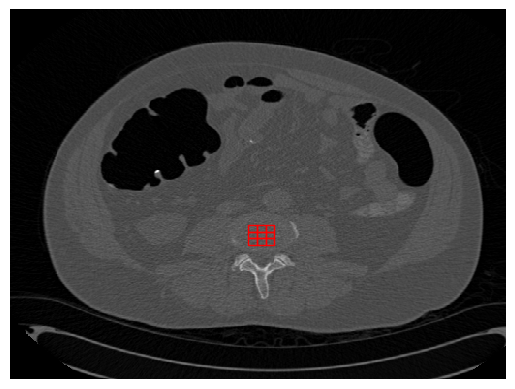

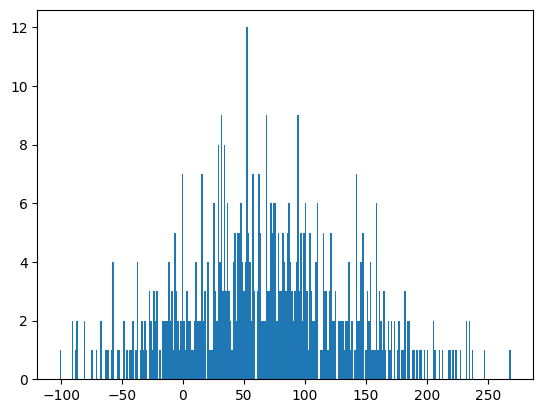

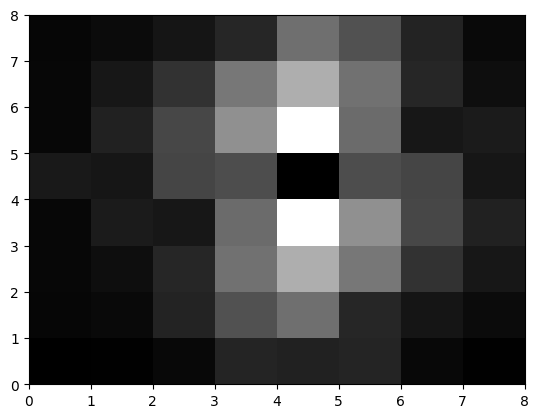

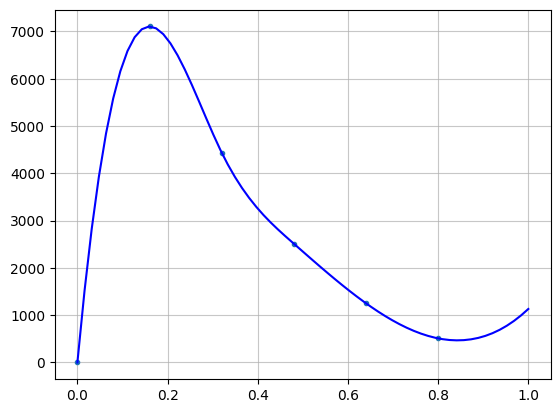

Mean : 68.91840277777777, var = 4526.880494671104


In [98]:
ROI_Noise_info(stacked[300], y0=190, x0=250, plotall = True,savepath="NOISE_CT_FG")

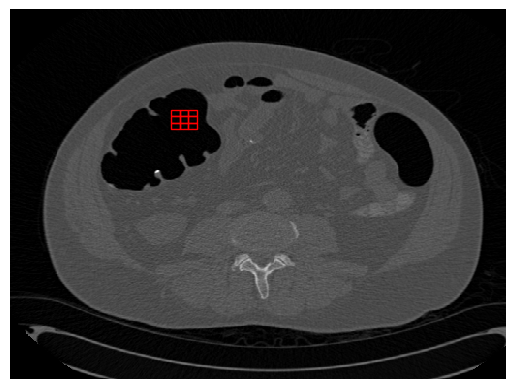

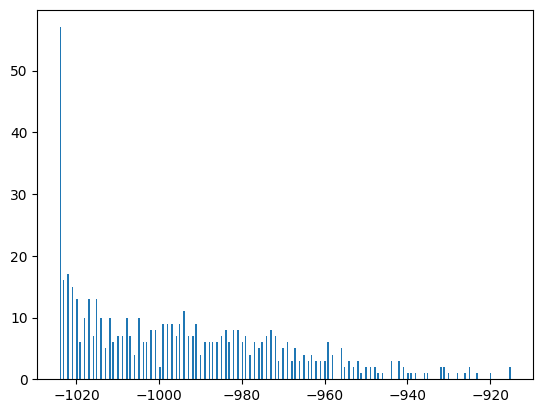

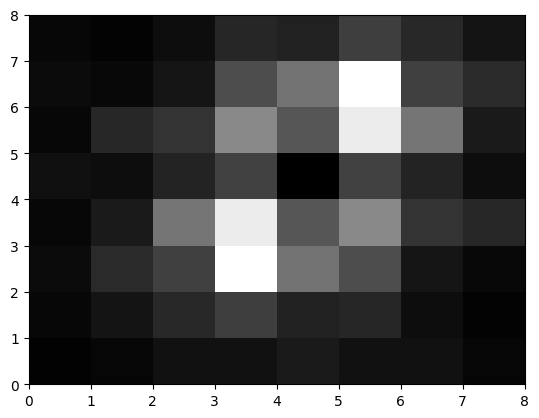

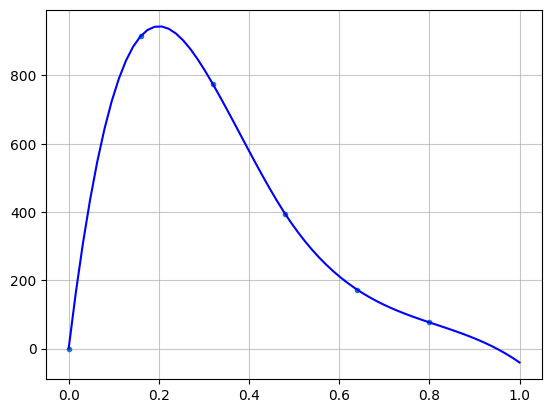

Mean : -994.3732638888889, var = 622.8971324025848


In [97]:
ROI_Noise_info(stacked[300], y0=350, x0=170, plotall = True, savepath="NOISE_CT_BG")

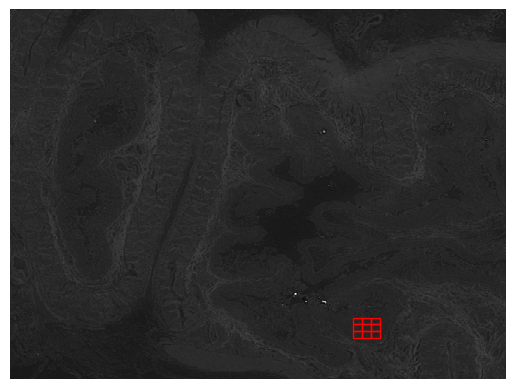

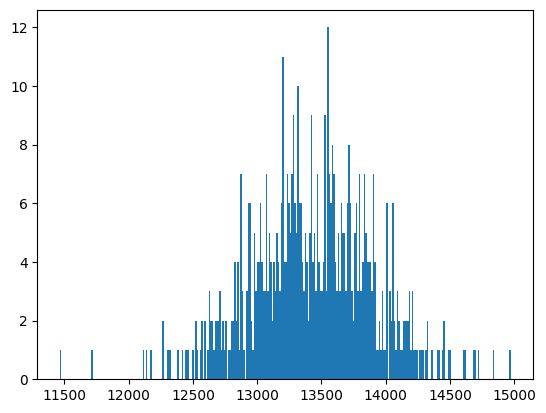

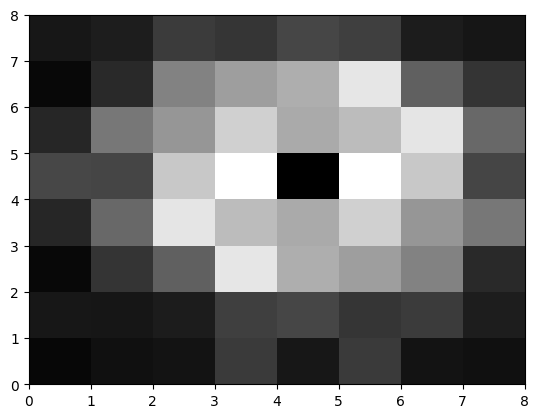

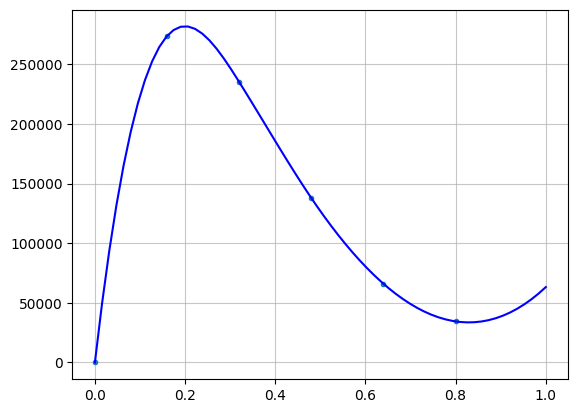

Mean : 13425.685763888889, var = 232027.70160288867


In [95]:
ROI_Noise_info(image_array_sych[90][2500:3000,2000:2500], y0=60, x0=350, size=9, plotall = True,savepath="NOISE_SYCH_FG")

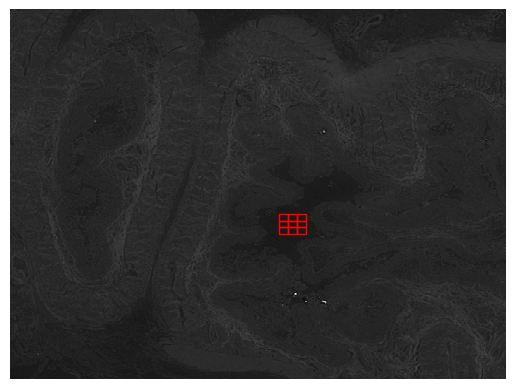

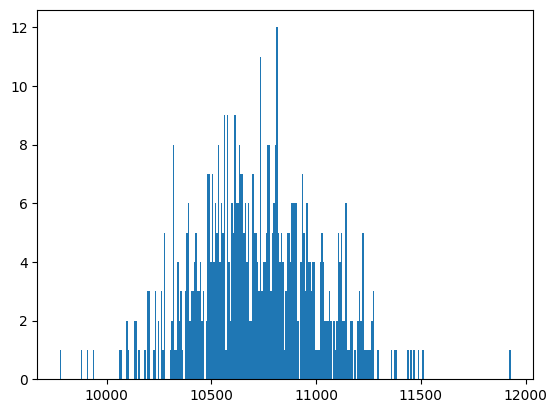

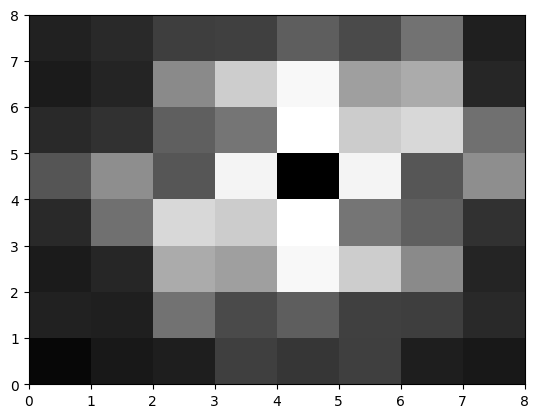

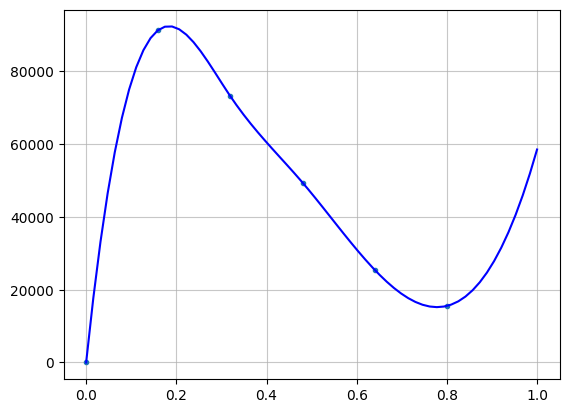

Mean : 10719.671875, var = 83476.23782009548


In [91]:
ROI_Noise_info(image_array_sych[90][2500:3000,2000:2500], y0=200, x0=275, size=9, plotall = True,savepath="NOISE_SYCH_BG")

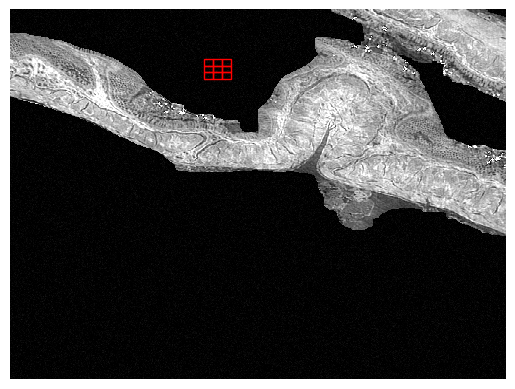

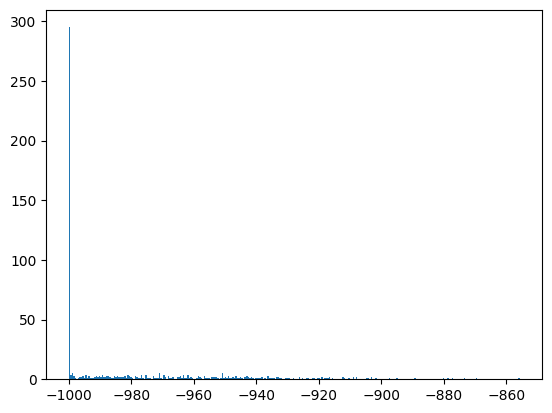

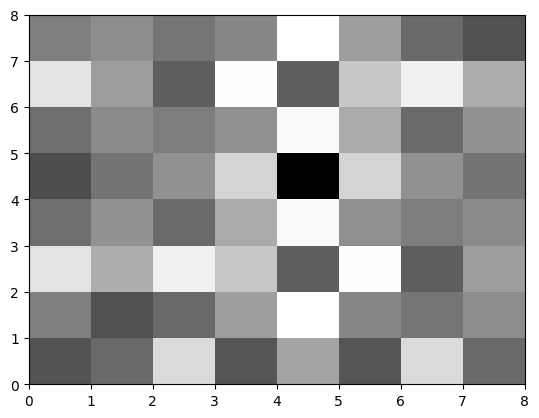

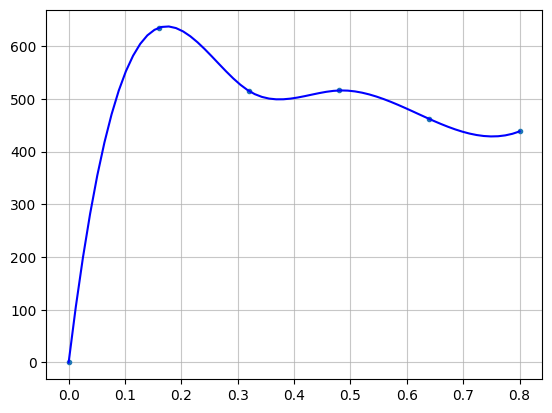

Mean : -980.6432878709776, var = 805.5712030397876


In [43]:
ROI_Noise_info(noisy_root_arr[500][500:1000, 1000:1500], y0=410, x0=200, size=9, max_x = 0.8, plotall = True, savepath="noise_final_bg")

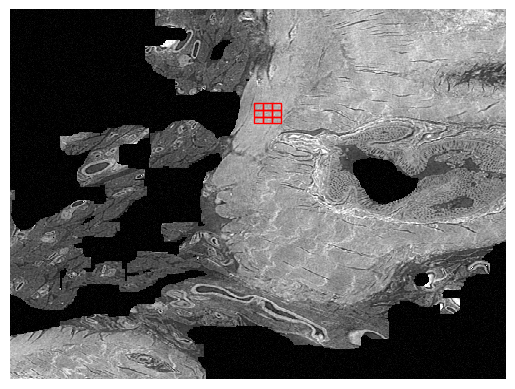

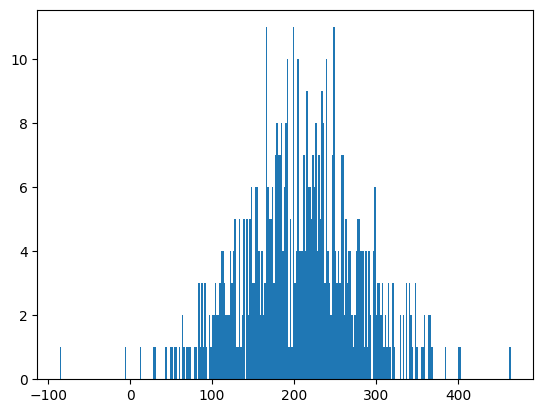

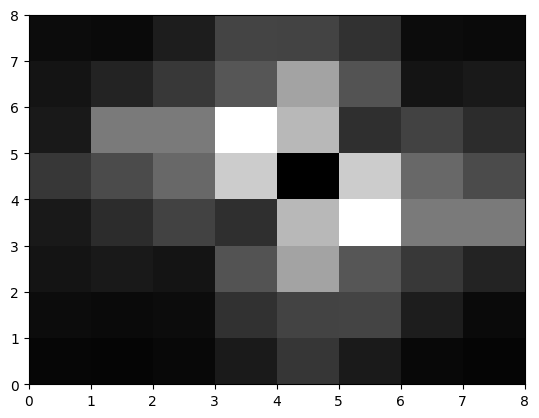

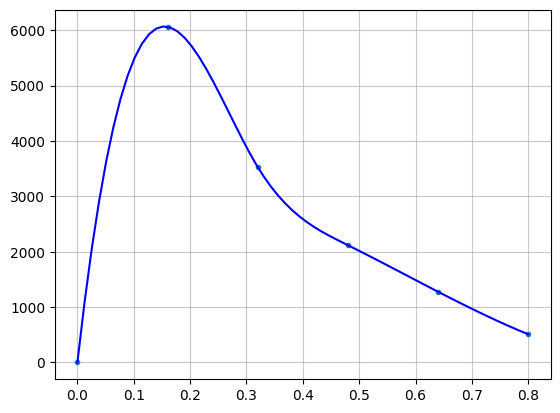

Mean : 207.79719328703698, var = 5060.577000205609


In [61]:
ROI_Noise_info(noisy_root_arr[500][1000:1500, 2200:2700], y0=350, x0=250, size=9, max_x = 0.8, plotall = True, savepath="final_noise_fg")

## Segmentation


In [190]:
def plot_image_with_variants(i, savepath = "./test"):

    image_file = image_files_sych[i]
    image = contrasted[i]
    titles = [
        "Original Image",
        "Otsu",
        "Method 1",
        "Method 2",
        "Method 3"
    ]
    
    # Prepare images for each subplot
    images = []
    
    # Original image
    images.append(image)
    
    # Otsu segmentation
    images.append(seg_otsu_arr[i])
    
    # ALL segmentation
    end_png = image_file.split('/')[-1].split('.jp2')[0] + '.png'
    kernel = np.ones((5, 5), np.uint8)
    segmask_path_ALL = os.path.join(segmentation_path_ALL, end_png)
    segmask_ALL = cv2.imread(segmask_path_ALL, cv2.IMREAD_GRAYSCALE)
    img_erosion_ALL = cv2.erode(segmask_ALL, kernel, iterations=3)
    mask_ALL = cv2.dilate(img_erosion_ALL, kernel, iterations=3)
    thresholded_image_ALL = np.where(mask_ALL > 0, image, 0)
    images.append(thresholded_image_ALL)
    
    # Aggressive segmentation
    segmask_path_AG = os.path.join(segmentation_result_Aggressive, end_png)
    segmask_AG = cv2.imread(segmask_path_AG, cv2.IMREAD_GRAYSCALE)
    img_erosion_AG = cv2.erode(segmask_AG, kernel, iterations=3)
    mask_AG = cv2.dilate(img_erosion_AG, kernel, iterations=3)
    thresholded_image_AG = np.where(mask_AG > 0, image, 0)
    images.append(thresholded_image_AG)
    
    # Root segmentation
    images.append(seg_root_arr[i])
    
    # Plot all images in a single figure
    plt.figure(figsize=(5, 15))
    for idx, img in enumerate(images):
        plt.subplot(5, 1, idx + 1)  # 5 rows, 1 column, current index
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(titles[idx], fontsize=12)  # Small title
    
    plt.tight_layout(pad = 0.1)
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', pad_inches=0.1, transparent=True)
    plt.show()


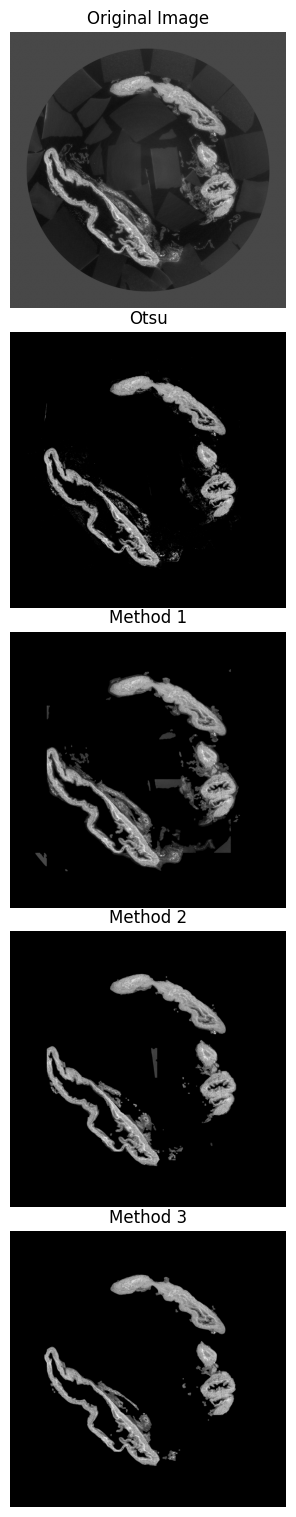

In [200]:
plot_image_with_variants(900, savepath="./test3")

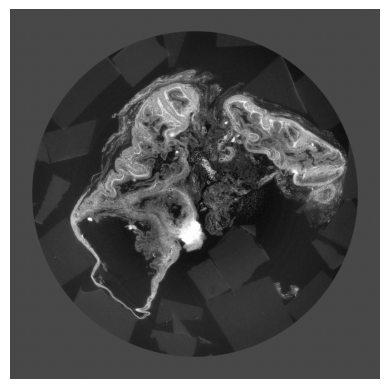

In [196]:
i = 1300
image_file = image_files_sych[i]
image = contrasted[i]

plt.imshow(image)
plt.axis('off')
plt.show()


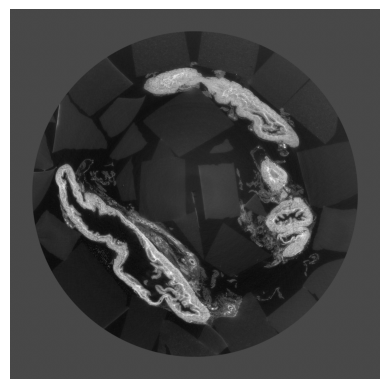

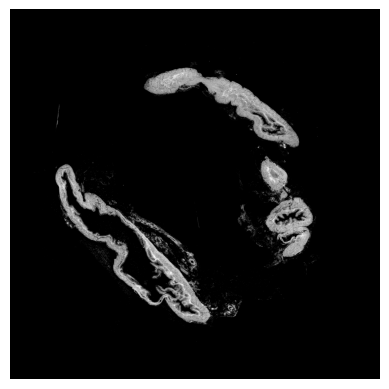

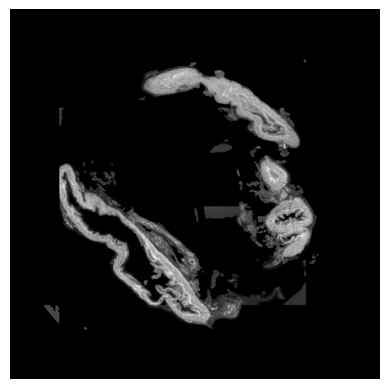

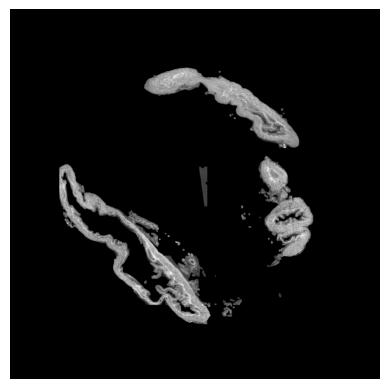

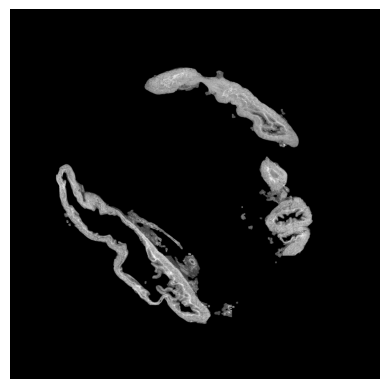

In [199]:
i = 900
image_file = image_files_sych[i]
image = contrasted[i]

plt.imshow(image)
plt.axis('off')
plt.show()


plt.imshow(seg_otsu_arr[i])
plt.axis('off')
plt.show()


# ALL
end_png = image_file.split('/')[-1].split('.jp2')[0] + '.png'#ROOT
kernel = np.ones((5, 5), np.uint8) 
segmask_path = os.path.join(segmentation_path_ALL, end_png)

segmask = cv2.imread(segmask_path, cv2.IMREAD_GRAYSCALE)

img_erosion = cv2.erode(segmask, kernel, iterations=3) 
mask = cv2.dilate(img_erosion, kernel, iterations=3) 
thresholded_image_root = np.where(mask > 0, image, 0)

plt.imshow(thresholded_image_root)
plt.axis('off')
plt.show()

# AG
kernel = np.ones((5, 5), np.uint8) 
segmask_path = os.path.join(segmentation_result_Aggressive, end_png)

segmask = cv2.imread(segmask_path, cv2.IMREAD_GRAYSCALE)

img_erosion = cv2.erode(segmask, kernel, iterations=3) 
mask = cv2.dilate(img_erosion, kernel, iterations=3) 
thresholded_image_root = np.where(mask > 0, image, 0)

plt.imshow(thresholded_image_root)
plt.axis('off')
plt.show()


plt.imshow(seg_root_arr[i])
plt.axis('off')
plt.show()

In [ ]:

end = image_file.split('/')[-1].split('.jp2')[0] + '.jpg'
end_png = image_file.split('/')[-1].split('.jp2')[0] + '.png'


In [ ]:

    # OTSU
    _, thresholded, mask = otsu(adjusted_contrast)
    transformed = transform(thresholded)
    noisy_image = backgroundNoise(transformed, mask)
    
    seg_otsu_arr.append(thresholded)
    transformed_otsu_arr.append(transformed)
    noisy_otsu_arr.append(noisy_image)
    plt.imsave(os.path.join(thres_filepath_otsu, end), thresholded)
    plt.imsave(os.path.join(transformed_filepath_otsu, end), transformed)
    plt.imsave(os.path.join(noisy_filepath_otsu, end), noisy_image)
    
    end = image_file.split('/')[-1].split('.jp2')[0] + '.jpg'
    end_png = image_file.split('/')[-1].split('.jp2')[0] + '.png'#ROOT
    kernel = np.ones((5, 5), np.uint8) 
    segmask_path = os.path.join(segmentation_path, end_png)
    
    segmask = cv2.imread(segmask_path, cv2.IMREAD_GRAYSCALE)
    
    img_erosion = cv2.erode(segmask, kernel, iterations=3) 
    mask = cv2.dilate(img_erosion, kernel, iterations=3) 
    thresholded_image_root = np.where(mask > 0, adjusted_contrast, 0)
    
    transformed_root = transform(thresholded_image_root)
    noisy_image_root = backgroundNoise(transformed_root, mask)
    
    
    seg_root_arr.append(thresholded_image_root)
    transformed_root_arr.append(transformed_root)
    noisy_root_arr.append(noisy_image_root)
    plt.imsave(os.path.join(thres_filepath_root, end), thresholded_image_root)
    plt.imsave(os.path.join(transformed_filepath_root, end), transformed_root)
    plt.imsave(os.path.join(noisy_filepath_root, end), noisy_image_root)
